In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import vice
import apogee_analysis as aah
from astropy.table import Table
import plotting
import fitsio
import astropy as ap
import astropy.units as u

In [3]:
file_name = "allStar-dr17-synspec_rev1.fits.1"

In [90]:
ff = fits.open(file_name, mmap=True)
da = ff[1].data
ff.close()

In [91]:
# cuts in W+19
mask = da["LOGG"] > 1
mask &= da["LOGG"] < 2
mask &= da["SNR"] > 80
filtered = da[mask]
# del da

Text(0, 0.5, 'log g')

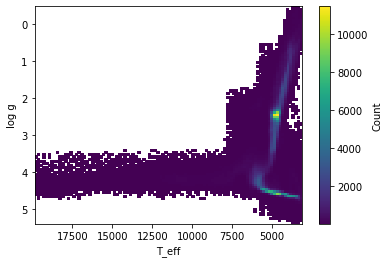

In [96]:
plotting.density_scatter(da["TEFF"], da["LOGG"], density=False)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("T_eff")
plt.ylabel("log g")

In [42]:
df = pd.DataFrame(filtered.tolist(), columns = [c.name for c in filtered.columns])

del filtered
del da

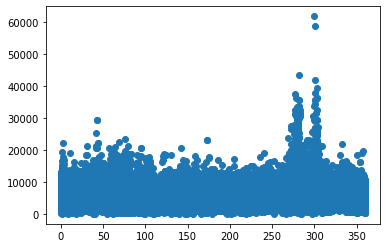

In [43]:
plt.scatter(df["GLON"], df["GAIAEDR3_R_MED_GEO"])

In [44]:
# Calculate galactocentric coordinates
import astropy.coordinates as coord
c = coord.SkyCoord(ra = df["RA"] * u.degree,
                           dec = df["DEC"] * u.degree,
                           distance = df["GAIAEDR3_R_MED_GEO"] * u.pc,
                           frame="icrs")
gc_c = c.transform_to(coord.Galactocentric)
df["R_gal"] = np.array(np.sqrt(gc_c.x**2 + gc_c.y**2) / 1e3)
df["th_gal"] = np.array(np.arctan(gc_c.y/gc_c.x))
df["abs_z"] = np.array(np.abs(gc_c.z) / 1e3)
df["z"] = np.array(gc_c.z / 1e3)


(-10.0, 10.0)

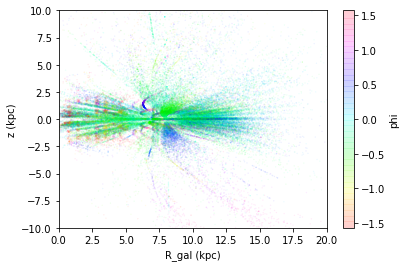

In [45]:
plt.scatter(df.R_gal, df.z, c=df.th_gal, s=0.1, alpha=0.1, cmap="hsv")
plt.colorbar(label="phi")
plt.xlabel("R_gal (kpc)")
plt.ylabel("z (kpc)")
plt.xlim(0, 20)
plt.ylim(-10, 10)

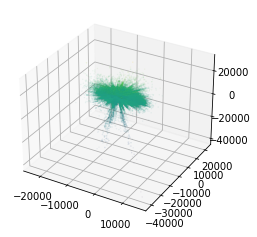

In [46]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(gc_c.x, gc_c.y, gc_c.z, s=0.1, alpha=0.1, c=gc_c.z)

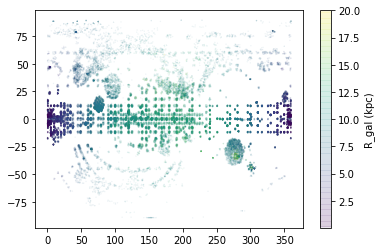

In [48]:
plt.scatter(df["GLON"], df["GLAT"], c=df.R_gal, s=0.1, alpha=0.1, vmax=20)
plt.colorbar(label="R_gal (kpc)")

In [86]:
def bracket(df, ele, ele2="H"):
    if ele2 == "H":
        if ele == "FE":
            return df["FE_H"]
        else:
            return df["%s_FE" % ele] + df["FE_H"]
    else:
        if ele2 == "FE":
            return df["%s_FE" % ele]
        else:
            return df["%s_FE" % ele] - df["%s_FE" % ele2]


In [50]:
df["O_H"] = bracket(df, "O")
df["C_O"] = bracket(df, "C", "O")
df["C_N"] = bracket(df, "C", "N")

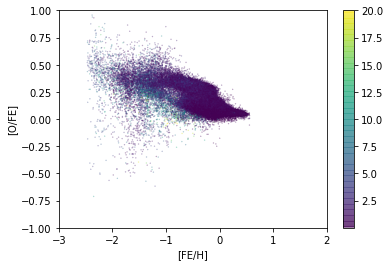

In [51]:
plt.scatter(df["FE_H"], df["O_FE"], c=df.abs_z, s=0.1, alpha=0.5, vmax=20)
plt.ylim(-1,1)
plt.xlim(-3,2)
plt.ylabel("[O/FE]")
plt.xlabel("[FE/H]")
plt.colorbar()

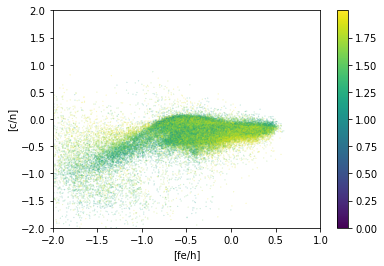

In [53]:
plt.scatter(df["FE_H"], df["C_N"], s=0.01, c=df["LOGG"], vmin=0)
plt.xlim(-2, 1)
plt.ylim(-2, 2)
plt.xlabel("[fe/h]")
plt.ylabel("[c/n]")
plt.colorbar()

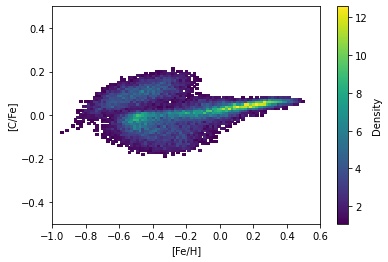

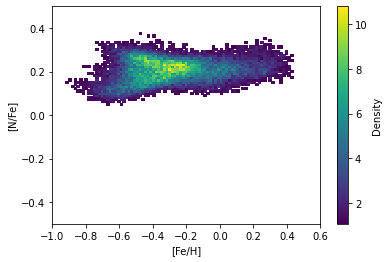

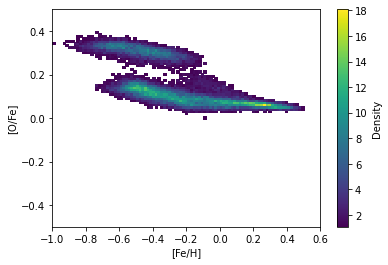

In [54]:
xlim = (-1, 0.6)
for ele in ["C", "N", "O"]:
    plotting.density_scatter(df["FE_H"], df["%s_FE" % ele], xlim=xlim, ylim=(-0.5, 0.5))
    plt.xlabel("[Fe/H]")
    plt.ylabel("[%s/Fe]" % ele)
    plt.show()

In [55]:
from sklearn.cluster import dbscan

In [56]:
filt_na = ~df[["FE_H", "O_FE"]].isna().any(axis=1)

In [57]:
core_samples, labels = dbscan(df[["FE_H", "O_FE"]][filt_na], eps=0.01, min_samples=60)

In [58]:
filt = (labels == 1) | (labels == 0)
split = df[filt_na].iloc[filt]
split["hi_alpha"] = labels[filt] == 1

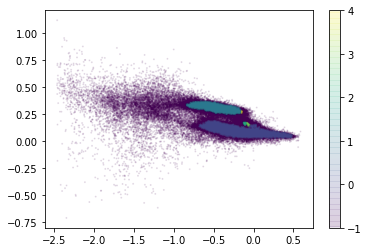

In [59]:
plt.scatter(df["FE_H"][filt_na], df["O_FE"][filt_na], c=labels, s=1, alpha=0.1)
plt.colorbar()

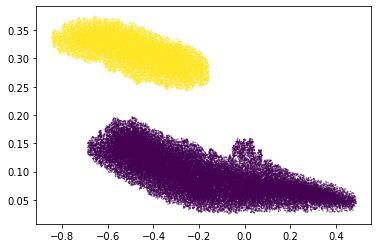

In [61]:
plt.scatter(split["FE_H"], split["O_FE"], c=split.hi_alpha, s=0.1)

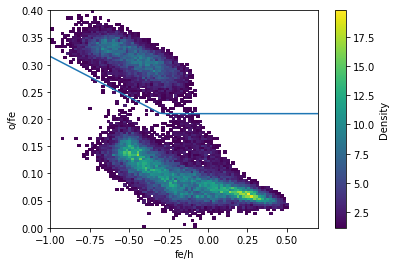

In [63]:

def o_fe_fe_h_cutoff(fe_h):
    return 0.21 - 0.15*(fe_h + 0.3) *(fe_h < -0.3)

plotting.density_scatter(df["FE_H"], df["O_FE"], xlim=(-1,0.7), ylim=(0, 0.4))
plt.xlabel("fe/h")
plt.ylabel('o/fe')
x = np.linspace(-1, 0.7)
y = o_fe_fe_h_cutoff(x)

plt.plot(x, y)

In [68]:
def plot_abundance_alpha(x="O_H", y="C_O", df=split, fig=None, ax=None, s=0.001):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
        
    x_vals = bracket(df, *x.split("_"))
    y_vals = bracket(df, *y.split("_"))
    ax.scatter(x_vals[df.hi_alpha], y_vals[df.hi_alpha], label="low SNIa", alpha=1, s=s)
    ax.scatter(x_vals[~df.hi_alpha], y_vals[~df.hi_alpha], label="high SNIa", alpha=1, s=s)
    ax.legend(markerscale=0.1/s)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    

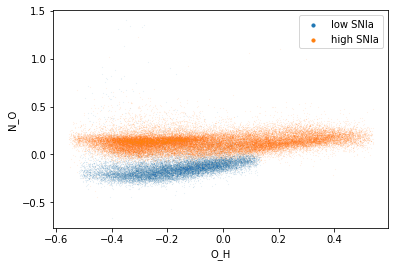

In [69]:
plot_abundance_alpha(y="N_O")

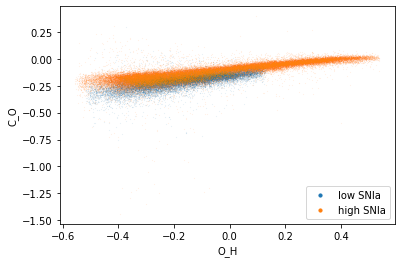

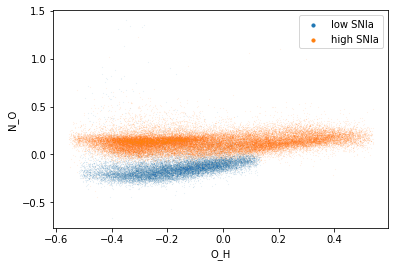

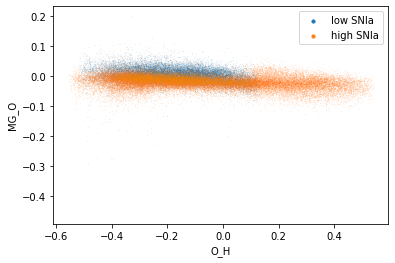

In [70]:
plot_abundance_alpha()
plt.show()

plot_abundance_alpha(y="N_O")
plt.show()

plot_abundance_alpha(y="MG_O")
plt.show()

In [73]:
def plot_in_gal_region(x="O_H", y="C_O", xlabel=None, ylabel=None):
    fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(20,15))
    for j in range(5):
        R_min, R_max = [(1, 3), (3, 5), (5,7), (7,9), (9,11), (11,13)][j]
    

        for i in range(3):
            z_min, z_max = [(0, 0.5), (0.5, 1), (1, 2)][i]
            ax = axs[j][i]
            mask = split.R_gal > R_min
            mask &= split.R_gal < R_max
            mask &= split.abs_z > z_min
            mask &= split.abs_z < z_max
            
            # plotting.density_scatter(x[mask], y[mask], fig=fig, ax=ax)
            plot_abundance_alpha(x, y, df = split[mask], fig=fig, ax=ax, s=0.01)

            if j==0:
                ax.set(title="z =  %1.1f - %1.1f" % (z_min, z_max))
            if i == 0:
                ax.set_ylabel("R = %i - %i" %(R_min, R_max))
            
            


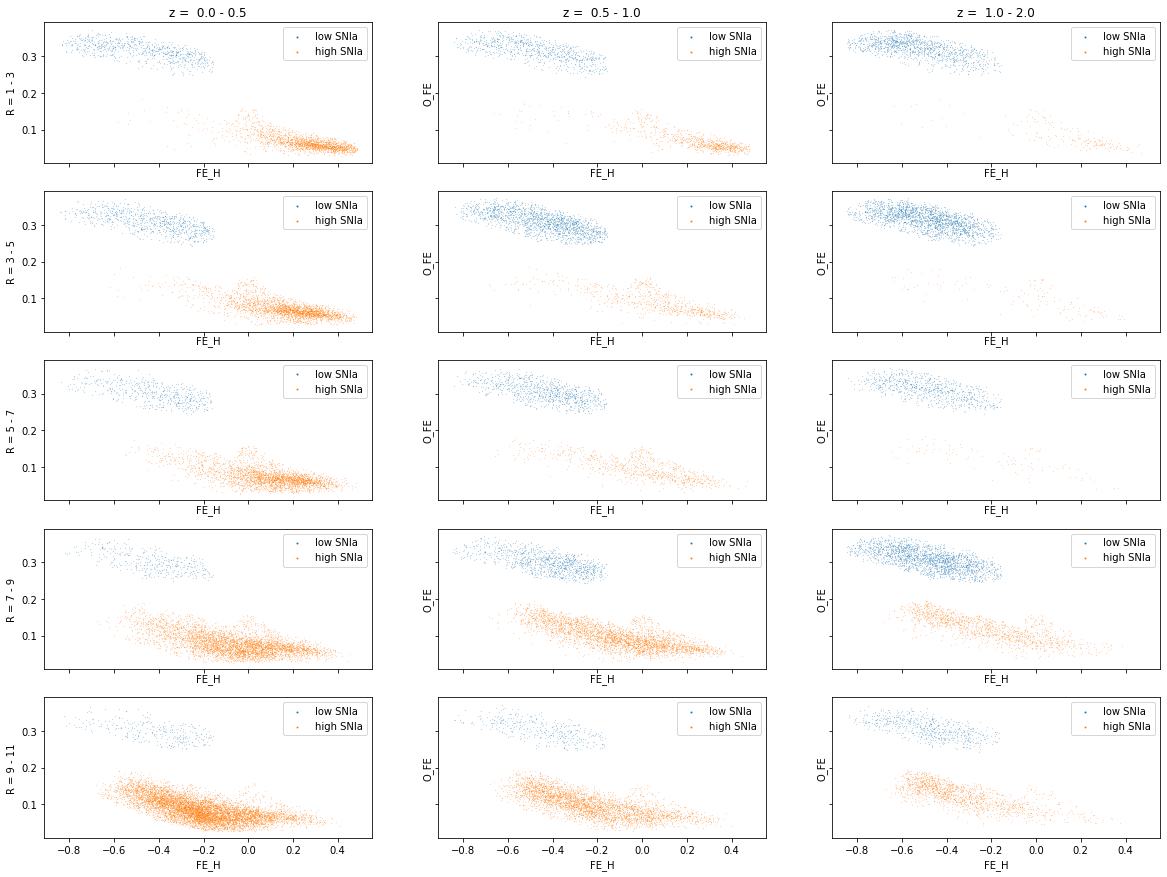

In [87]:
plot_in_gal_region(x = "FE_H", y="O_FE")

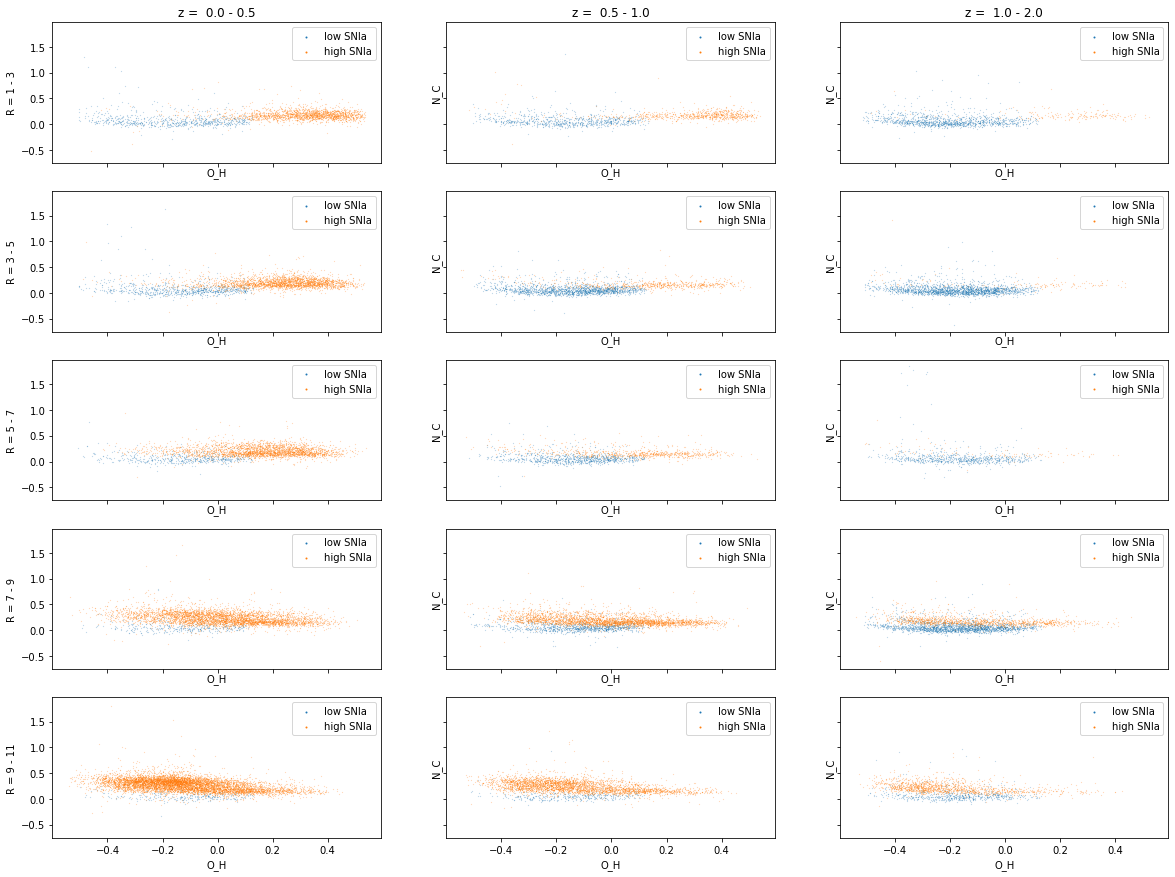

In [74]:
plot_in_gal_region(y="N_C")

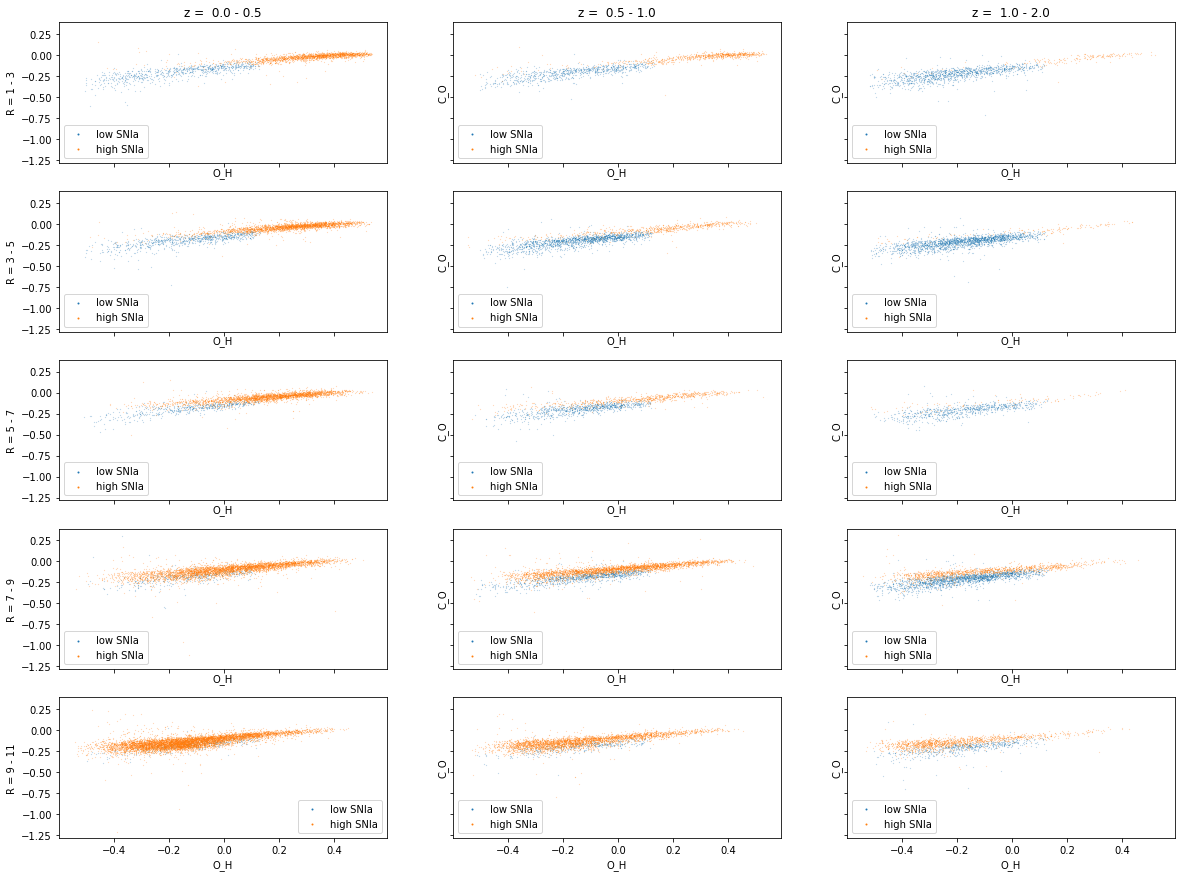

In [75]:
plot_in_gal_region(y="C_O")

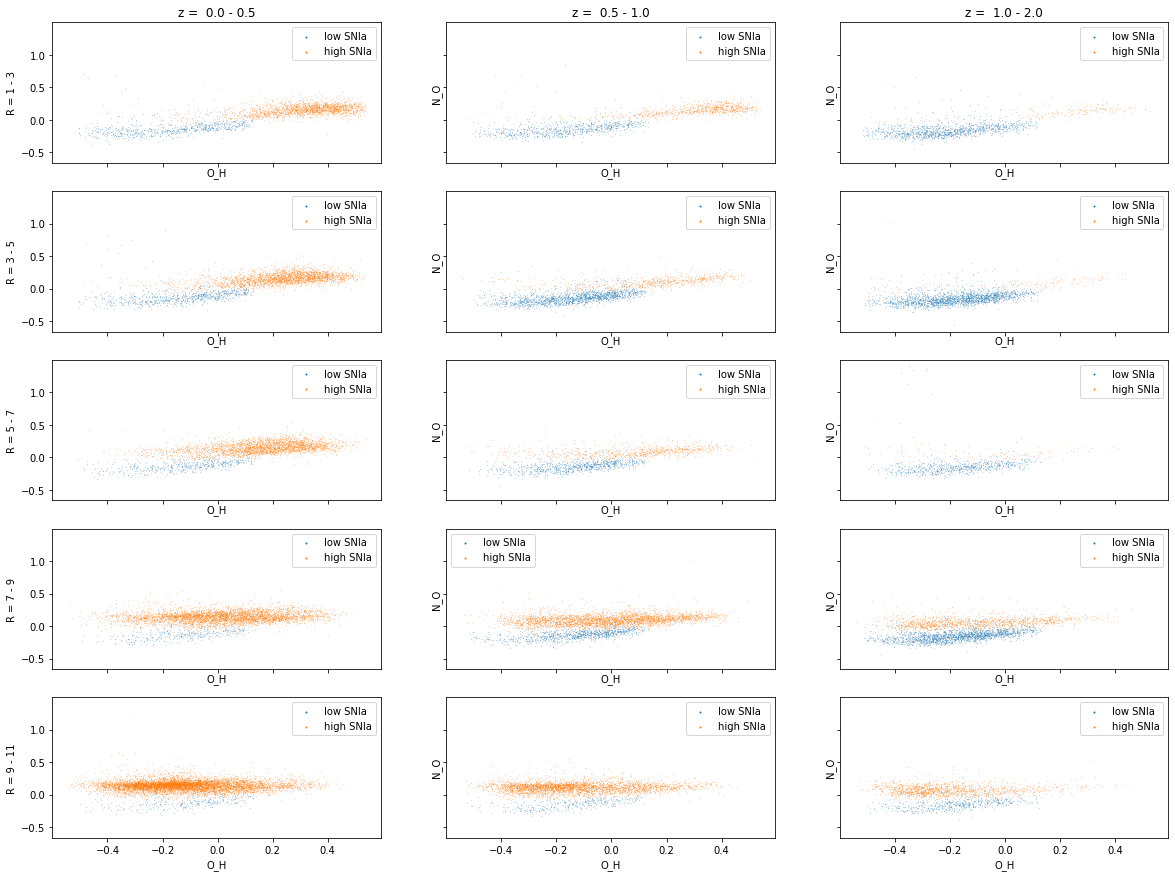

In [97]:
plot_in_gal_region(y="N_O")

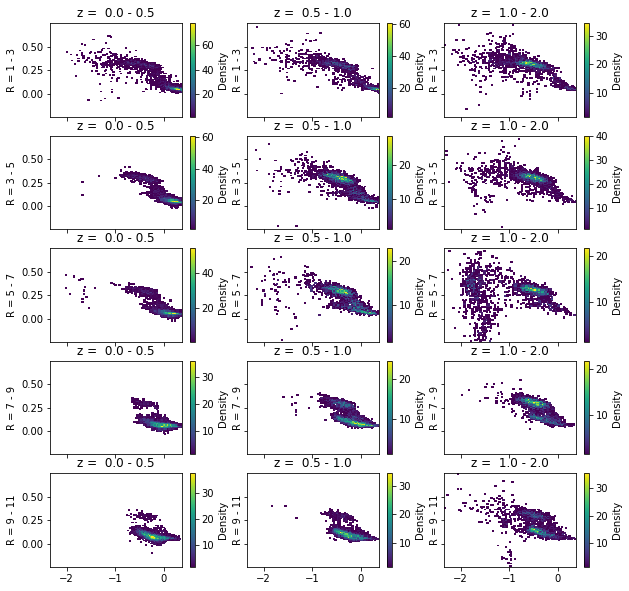

In [77]:
plot_in_gal_region(filtered["FE_H"], filtered["O_FE"])

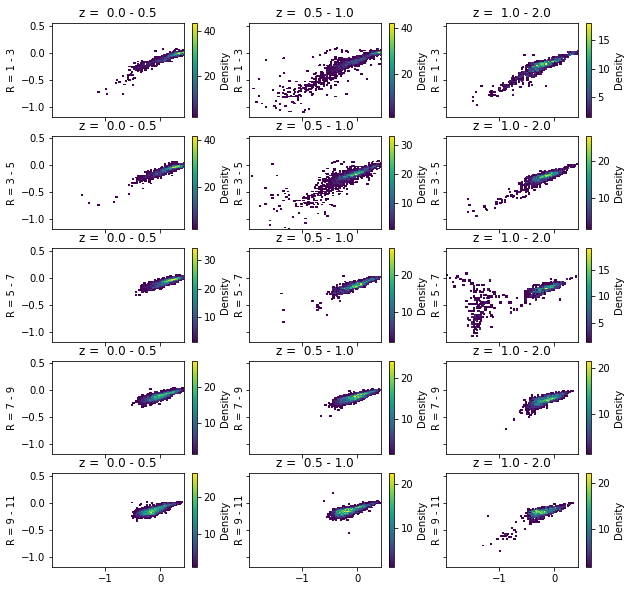

In [78]:
plot_in_gal_region(o_h, c_o, xlabel="[O/H]", ylabel="[C/O]")

In [ ]:
plotting.density_scatter(T, logg)

In [ ]:
v21 = aah.vincenzo2021()

In [ ]:
plt.scatter(v21["[o/h]"], v21["[c/o]"], s=0.1, alpha=0.2, label="V21")
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")
plt.scatter(o_h, c_o, s=0.1, alpha=0.1, label="APOGEE")
plt.xlim(-1,0.7)
plt.ylim(-0.7, 0.6)
plt.legend(markerscale=10)

In [ ]:
f = open("CNOdredgeup.obj", "rb")
raw = pickle.load(f, encoding = "bytes")
f.close()

In [ ]:
raw

In [ ]:
plt.hist(filtered["VSINI"][filtered["VSINI"] > 0])

In [ ]:
plt.scatter(v21["[o/h]"], v21["[c/o]"], s=1)
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

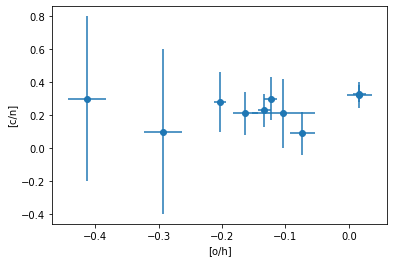

Text(0, 0.5, '[c/o]')

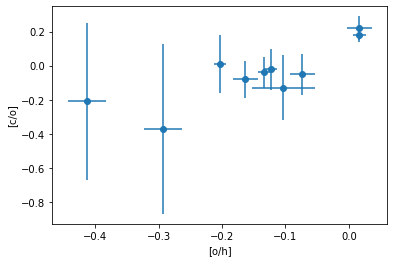

In [35]:
# rom skillman 2020, table 2
# https://ui.adsabs.harvard.edu/abs/2020ApJ...894..138S/abstract

aah.plot_skillman20_cnoh()
plt.xlabel("[o/h]")
plt.ylabel("[c/n]")
plt.show()
aah.plot_skillman20_cooh()
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

Text(0, 0.5, '[c/o]')

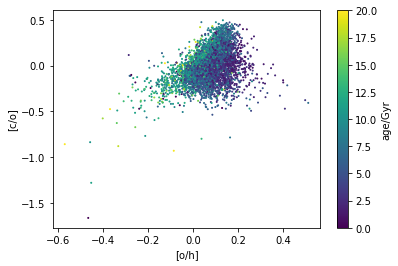

In [165]:
plt.scatter(v21["[c/o]"] , v21["[o/h]"], c=v21["age"], vmin=0, s=1)
plt.colorbar(label="age/Gyr")
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

# MultiProcess Model

Trying to apply methods from W+19 to AGB star yields. 